# Store Item Demand Forecasting

# Initial imports

In [ ]:
%pip install ipython-autotime --upgrade
#%pip install scikit-learn     --upgrade

In [1]:
from google.colab import drive, files
import pandas as pd
import warnings
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
%load_ext autotime

Mounted at /content/drive
time: 722 µs (started: 2023-06-09 17:23:20 +00:00)


In [35]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/store-item-demand-forecasting/train.csv", encoding='utf-8', parse_dates=['date'])

time: 822 ms (started: 2023-06-09 17:32:50 +00:00)


# EDA

In [ ]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


time: 13.1 ms (started: 2023-06-04 18:28:07 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
time: 58.5 ms (started: 2023-06-05 12:56:07 +00:00)


A tarefa é prever os três meses seguintes de vendas, mas o conjunto de dados contém registros diários. Vou transformá-lo para registros mensais. Normalmente eu faço transformações nos dados na fase de engenharia de atributos, mas como esse tipo de transformação vai influenciar até mesmo a visualização de dados, farei logo no início da análise exploratória.

**Etapa ##:** Mantenho somente os anos e meses nas datas. Os dias(01) aparecem apenas porque são definidos por padrão.

In [36]:
#dataset['date'] = dataset['date'].dt.strftime('%Y-%m') # o novo atributo se transforma em object.
#dataset["date"] = pd.to_datetime(dataset["date"])

dataset['date'] = dataset['date'].dt.to_period('M') # o novo atributo se transforma em period[M].
dataset['date'] = pd.PeriodIndex(dataset['date'], freq='M').to_timestamp()

time: 212 ms (started: 2023-06-09 17:32:57 +00:00)


**Etapa ##:** Somo a quantidade de vendas de cada item em cada loja mensalmente.

In [37]:
dataset = dataset.groupby(['store', 'item', 'date'])['sales'].sum().reset_index()
dataset = dataset[['date', 'store', 'item', 'sales']] # reordeno as colunas apenas para ficar mais legível
dataset

,date,store,item,sales
0,2013-01-01,1,1,328
1,2013-02-01,1,1,322
2,2013-03-01,1,1,477
3,2013-04-01,1,1,522
4,2013-05-01,1,1,531
...,...,...,...,...
29995,2017-08-01,10,50,2867
29996,2017-09-01,10,50,2586
29997,2017-10-01,10,50,2507
29998,2017-11-01,10,50,2574


time: 178 ms (started: 2023-06-09 17:32:57 +00:00)


**Etapa ##:** Defino as datas como sendo o index do dataframe.

In [38]:
dataset = dataset.set_index('date')

time: 3.7 ms (started: 2023-06-09 17:33:02 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30000 entries, 2013-01-01 to 2017-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store   30000 non-null  int64
 1   item    30000 non-null  int64
 2   sales   30000 non-null  int64
dtypes: int64(3)
memory usage: 937.5 KB
time: 13.9 ms (started: 2023-06-06 13:26:24 +00:00)


In [ ]:
dataset.describe()

,store,item,sales
count,30000.000000,30000.00000,30000.000000
mean,5.500000,25.50000,1590.150400
std,2.872329,14.43111,824.119569
min,1.000000,1.00000,211.000000
25%,3.000000,13.00000,925.000000
50%,5.500000,25.50000,1449.000000
75%,8.000000,38.00000,2112.000000
max,10.000000,50.00000,5109.000000


time: 25.3 ms (started: 2023-06-06 13:26:28 +00:00)


## Data visualization

Vou usar nessa etapa um modelo de regressão linear para capturar a tendêndia das distribuições que pretendo visualizar. Através dele posso desenhar a linha da tendência nos gráficos.

In [39]:
from sklearn.linear_model import LinearRegression

import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.random.default_rng()

colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

time: 4.86 ms (started: 2023-06-09 17:33:11 +00:00)


Considerando um ano, loja, e item quaisquer, vou fazer uma visualização mensal para verificar se há alguma sazonalidade ou tendência.

As funções da célula abaixo são úteis para fazer as visualizações. Além disso, o ideal seria criar gráficos de boa parte dos itens e lojas, mas como seriam 500 gráficos(50 itens e 10 lojas), preferi fazer de outro jeito. Através das funções abaixo, posso executar quantas vezes eu quiser as células que contem o código de visualização e cada vez um novo gráfico será criado. Este será referente a um item aleatório de uma loja aleatória podendo ser de um ano ano qualquer ou do histórico completo.

In [ ]:
def get_date_range(sample):
  """
  Obtém um objeto do tipo date_rage com 'freq' definida em 'MS'. 
  Isso será fundamental para formar um ps.Series que será usado pela classe do sktime ForecastingHorizon.
  """
  start_date = sample.index[0]
  index_end  = sample.index[-1]
  return pd.date_range(start=start_date, end=index_end, freq='MS')



def get_sample_sales(dataset, one_year=True):
  """
  Forma um pd.Series com uma amostra de um ano de vendas. 
  """
  #dataset       = dataset.copy()
  #dataset.index = dataset.index.to_timestamp()

  dataset_sample = random_sample_sales(dataset, one_year)
  date_range     = get_date_range(dataset_sample)
  
  sales       = dataset_sample['sales']
  sales.index = date_range
  return sales



def random_sample_sales(dataset, one_year=True):
  """
  Obtém uma amostra aleatória correspondente a um ano de vendas do dataset ou ao histórico interio.
  """
  store = np.random.randint(1, 11)
  item  = np.random.randint(1, 51)
  year  = np.random.randint(2013, 2018)
  
  if one_year:
    mask  = (dataset.index.year == year) & (dataset['store'] == store) & (dataset['item'] == item)
  else:
    mask  = (dataset['store'] == store) & (dataset['item'] == item)
  return dataset[mask]

time: 1.36 ms (started: 2023-06-08 20:24:15 +00:00)


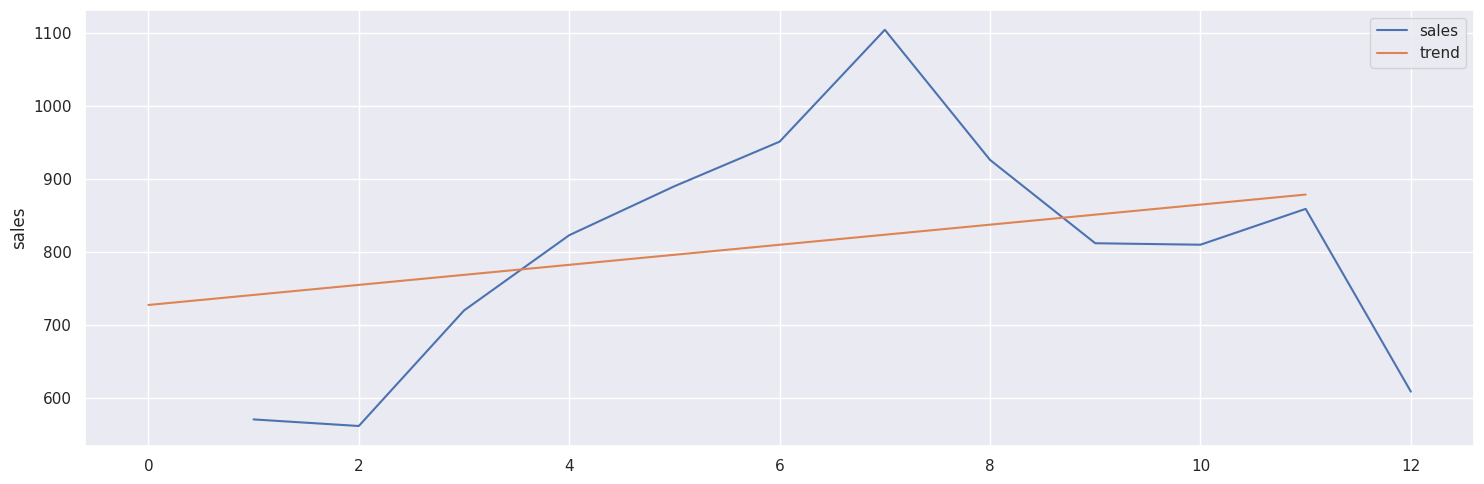

time: 447 ms (started: 2023-06-08 20:24:19 +00:00)


In [ ]:
sales = get_sample_sales(dataset, one_year=True)
sales.index = np.arange(1, 13) # pequeno ajuste para o modelo funcionar, as datas são substituídas por meses [1, 12]

lr = LinearRegression()
lr.fit(sales.index.to_numpy().reshape(-1, 1), sales.values)
y_pred = lr.predict(sales.index.to_numpy().reshape(-1, 1))

sns.set(rc={'figure.figsize':(15, 5)})
axs = sns.lineplot(data=sales, color=colors[0], label='sales')
sns.lineplot(data=y_pred, color=colors[1], label='trend', ax=axs)

plt.tight_layout()
plt.show()

**Conclusão:** Executando várias vezes a célula acima podemos concluir que não há sazonlidade mensal de vendas e uma leve tendência crescente em alguns anos. 

Há, no entanto, um pico de vendas sempre em torno do mês 7. Considerando que esse conjunto de dados é americano, esse padrão se deve, provavelmente, por causa do verão e das férias.

Agora, vou escolher uma loja e um item qualquer para analisar o histórico de vendas ao longo de todos os anos registrados mês a mês.

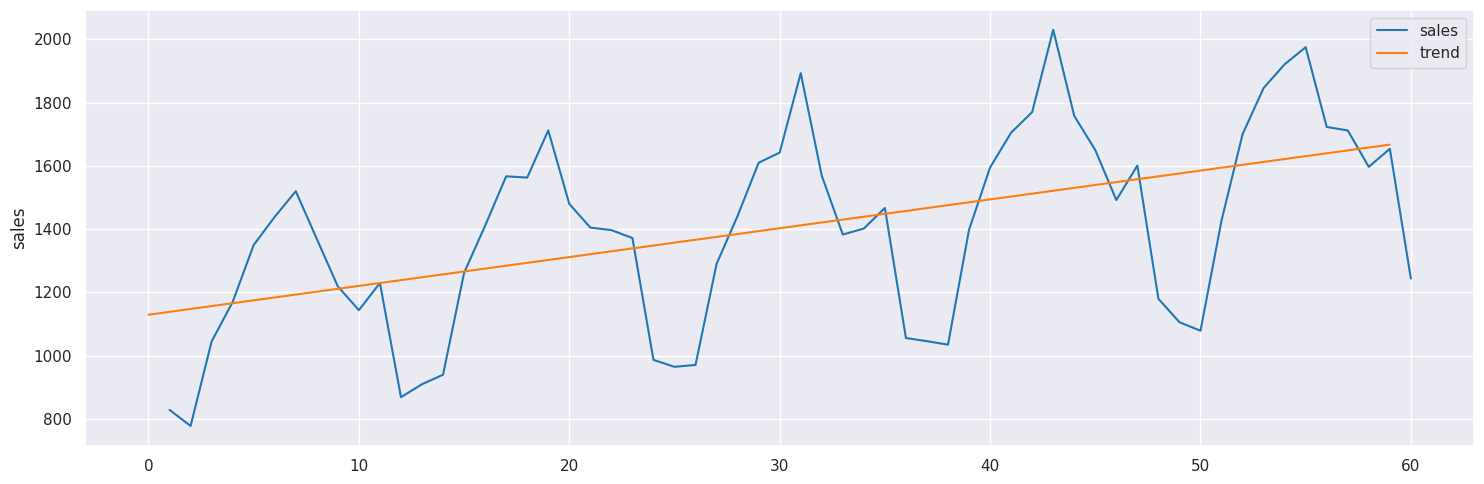

time: 333 ms (started: 2023-06-08 13:41:35 +00:00)


In [ ]:
sales = get_sample_sales(dataset, one_year=False)
sales.index = np.arange(1, (len(sales) + 1))

lr = LinearRegression()
lr.fit(sales.index.to_numpy().reshape(-1, 1), sales.values)
y_pred = lr.predict(sales.index.to_numpy().reshape(-1, 1))

sns.set(rc={'figure.figsize':(15, 5)})
axs = sns.lineplot(data=sales, color=colors[0], label='sales')
sns.lineplot(data=y_pred, color=colors[1], label='trend', ax=axs)

plt.tight_layout()
plt.show()

**Conclusão:** Executando várias vezes a célula acima, é possível observar sazonalidade ao longo dos anos com picos sempre por volta do mês 7 e vales sempre no ínicio e fim de cada ano. Também conseguimos ver uma leve tendência de aumento de vendas no decorrer do tempo.

# Train/Test split

Meu conjunto de teste será correspondente a um ano. Como sei que o último ano é 2017, vou usar os 12 meses dele.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

time: 491 µs (started: 2023-06-09 17:33:13 +00:00)


In [41]:
mask = dataset.index.year < 2017

train_set = dataset[mask]
test_set  = dataset[~mask]

time: 11.2 ms (started: 2023-06-09 17:33:16 +00:00)


As linhas verticais do gráfico abaixo representam cada mês do ano.

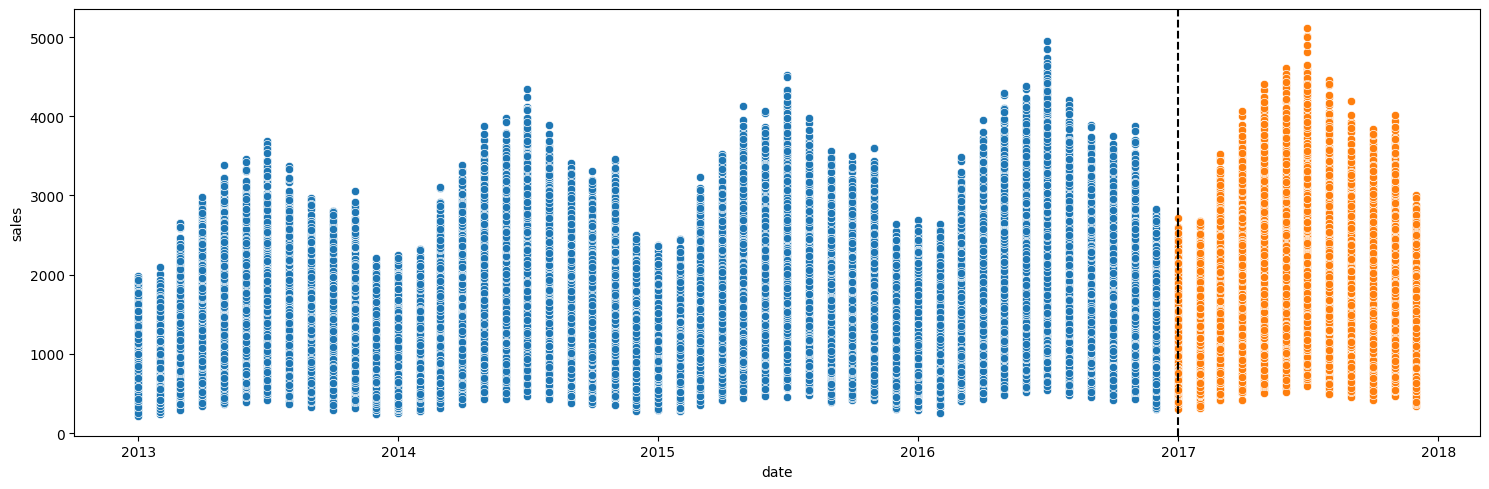

time: 718 ms (started: 2023-06-09 17:33:18 +00:00)


In [42]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.scatterplot(x=train_set.index, y=train_set['sales'], ax=axs)
sns.scatterplot(x=test_set.index, y=test_set['sales'], ax=axs)

plt.tight_layout()
plt.show()

A classe abaixo servirá para criar lag e forward features na etapa de feature engineering. Vou usá-la aqui para criar as labels(forward features) representando a quantidade de vendas feitas no primeiro, segundo e terceiro mês seguinte. 

In [43]:
class LagForwardFeatures(BaseEstimator, TransformerMixin):
  """
  Cria uma quantidade n de lag ou forward features.
  """
  def __init__(self, lag_size=0):
    if lag_size < 0:
      self.init = lag_size
      self.end  = 0
      self.lag_forward = 'forward'
    else:
      self.init = 1
      self.end  = lag_size + 1
      self.lag_forward = 'lag'

  def fit(self, X, y=None):
    return self
    
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X = X.copy()
    for i in range(self.init, self.end):
      col_name = 'sales_' + self.lag_forward + '_' + str(np.abs(i))
      X[col_name] = X.groupby(['store', 'item'])['sales'].shift(i)
    return X

time: 4.62 ms (started: 2023-06-09 17:33:25 +00:00)


In [44]:
fwrd_feat = LagForwardFeatures(lag_size=-3)
train_set = fwrd_feat.fit_transform(train_set)
test_set  = fwrd_feat.transform(test_set)

y_train   = train_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_train   = train_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)

y_test    = test_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_test    = test_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)

time: 31.4 ms (started: 2023-06-09 17:33:27 +00:00)


Por causa do seu mecanismo, um efeito potencialmente problemático das lag features é que elas possuem valores NaN nas suas extremidades. Para atenuar esse problema, vou imputar o número zero nesses registros. Não é a melhor estratégia, mas não será catastrófica.

Além disso, vou ordenar os conjuntos de treinamento e teste por ordem de data. Isso não vai afetar a engenharia de atributos, mas vai fazer diferença no treinamento dos modelos.

In [45]:
y_train   = y_train.fillna(0)
y_test    = y_test.fillna(0)

X_train = X_train.sort_index()
X_test  = X_test.sort_index()

y_train = y_train.sort_index()
y_test  = y_test.sort_index()

time: 11.9 ms (started: 2023-06-09 17:33:31 +00:00)


# Feature engineering.

In [46]:
from scipy.stats             import boxcox
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import MinMaxScaler, OrdinalEncoder, PowerTransformer

import math

time: 949 µs (started: 2023-06-09 17:33:36 +00:00)


**Etapa ##:** Crio lag features com os três meses de vendas anteriores.


In [47]:
pp_lag = Pipeline(steps=[('lag_features', LagForwardFeatures(lag_size=3))])

time: 631 µs (started: 2023-06-09 17:33:40 +00:00)


**Etapa ##:** Extraio novos atributos a partir das datas.
1.   Ano
2.   Mês
4.   Estações do ano
5.   Quartis de cada ano.


In [48]:
class DatesFeatures(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_season(self, month):
    if month in [12, 1, 2]:
      return "Winter"
    elif month in [3, 4, 5]:
      return "Spring"
    elif month in [6, 7, 8]:
      return "Summer"
    else:
      return "Fall"

  def transform(self, X, y=None):
    X = X.copy()
    #X = X.assign(season=X.index.month.map(self.get_season))
    X['year']    = X.index.year
    X['month']   = X.index.month
    X['season']  = np.vectorize(self.get_season)(X.index.month)
    X['quarter'] = X.index.to_period('Q')
    return X

time: 1.31 ms (started: 2023-06-09 17:33:40 +00:00)


In [49]:
pp_dates = Pipeline(steps=[('dates_features', DatesFeatures())])

time: 609 µs (started: 2023-06-09 17:33:43 +00:00)


**Etapa ##:** Crio atributos contendo a diferença de vendas entre o mês corrente e os três meses anteriores e outras medidas estatísticas, como:

*   Maior valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Menor valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Média de vendas entre a corrente e as dos três meses anteriores.
*   Desvio padrão de vendas entre a corrente e as dos três meses anteriores.

Essas medidas estatísticas podems ajudar o modelo preditor, mas não é uma certeza.

In [50]:
class StatisticSales(BaseEstimator, TransformerMixin):
  """
  Calcula estatísticas de um conjunto de dados, como: 
  * diferença entre o valor corrente e n passos atrás
  * max(), min(), mean(), std() entre o valor atuale n passos atrás
  """
  def __init__(self, size=0):
    self.size = size + 1

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_diff(self, X, y=None):
    for i in range(1, self.size):
      col_name = 'sales_diff_' + str(i)
      X[col_name] = X.groupby(['store', 'item'])['sales'].diff(i)
    return X

  def get_stats(self, X, y=None):
    X = X.sort_values(['store', 'item']) # se eu não fizer isso,  recebo: "ValueError: cannot reindex on an axis with duplicate labels"
    for i in range(2, self.size + 1): # precisa ser +1 porque rolling considera também a linha corrente
      max_name  = 'sales_max_'  + str(i - 1)
      min_name  = 'sales_min_'  + str(i - 1)
      mean_name = 'sales_mean_' + str(i - 1)
      std_name  = 'sales_std_'  + str(i - 1)
      X[max_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).max().reset_index(level=[0, 1], drop=True)
      X[min_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).min().reset_index(level=[0, 1], drop=True)
      X[mean_name] = X.groupby(['store', 'item'])['sales'].rolling(i).mean().reset_index(level=[0, 1], drop=True)
      X[std_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).std().reset_index(level=[0, 1], drop=True)
    return X.sort_index() # reordena os registros por ordem de data antes de retornar

  def transform(self, X, y=None):
    X = X.copy()
    X = self.get_diff(X)
    X = self.get_stats(X)
    return X

time: 2.65 ms (started: 2023-06-09 17:33:45 +00:00)


In [51]:
pp_stats = Pipeline(steps=[('stats_features', StatisticSales(size=3))])

time: 593 µs (started: 2023-06-09 17:33:50 +00:00)


**Etapa ##:** O conjunto de dados possui datas de 2013 até 2017 se repetindo em ciclos inúmeras vezes. Isso acontece por causa das lojas e itens. Para fazer com que os modelos de machine learning entendam esses ciclos eu codifico os atributos cíclicos(year, month, season, quarter) decompondo-os em componentes seno e conseno. Só depois disso posso remover os atributos 'year', 'month', 'season' e 'quarter' do conjunto.

In [52]:
class CyclicEncoder(OrdinalEncoder):
  """
  Esta classe deve ser usada sozinha ou dentro de um Pipeline.
  """
  def __init__(self, cyclical_cols):
    super().__init__(handle_unknown='use_encoded_value', unknown_value=-1)
    self.cyclical_cols = cyclical_cols

  def create_cyclic_names(self):
    cols_names = []
    for name in self.cyclical_cols:
      cols_names.append("sin_" + name)
      cols_names.append("cos_" + name)
    return cols_names
    
  def fit(self, X, y=None):
    return super().fit(X[self.cyclical_cols])

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_ordinal = super().transform(X[self.cyclical_cols])
    X_aux = []
    cols = range(X_ordinal.shape[1])
    for index in cols:
      column = X_ordinal[:, index]
      max_value = column.max()
      sin_values = [math.sin((2 * math.pi * x) / max_value) for x in list(column)]
      cos_values = [math.cos((2 * math.pi * x) / max_value) for x in list(column)]
      X_aux.append(sin_values)
      X_aux.append(cos_values)
    X_encoded = np.array(X_aux).transpose()
    cyclical_features = pd.DataFrame(data=X_encoded, columns=self.create_cyclic_names())
    cyclical_features = cyclical_features.set_index(X.index)
    X = pd.concat([cyclical_features, X], axis=1)
    return X.drop(self.cyclical_cols, axis=1)

time: 3.03 ms (started: 2023-06-09 17:33:53 +00:00)


In [53]:
pp_cyclical = Pipeline(steps=[('cyclical_encoding', CyclicEncoder(['year', 'month', 'season', 'quarter']))])

time: 563 µs (started: 2023-06-09 17:33:58 +00:00)


**Etapa ##:** Imputo valores nos registros que contém NaN.

In [54]:
pp_imputer = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='constant', fill_value=0))])

time: 685 µs (started: 2023-06-09 17:33:58 +00:00)


**Etapa ##:** Escalono o conjunto para que seus valores fiquem no intervalo [0, 1]. Vou fazer um pequeno ajuste na classe MinMaxScaler para que após o escalonamento todos os valores do conjnuto sejam acrescidos +1. Isso garantirá que todos sejam positivos e assim poderei normalizá-los com BoxCox.

In [55]:
class CustomMinMaxScaler(MinMaxScaler):
  def fit(self, X, y=None):
    return super().fit(X, y)
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X)

  def transform(self, X, y=None):
    X = super().transform(X)
    return (X + 1)

time: 850 µs (started: 2023-06-09 17:34:02 +00:00)


In [56]:
pp_scaler = Pipeline(steps=[('custom_min_max_scaler', CustomMinMaxScaler())])

time: 631 µs (started: 2023-06-09 17:34:04 +00:00)


**Etapa ##:** Normalizo a distribuição de dados coluna a coluna utilizando a técnica boxcox. Isso fará com que cada coluna tenha uma distribuição próxima da distribuição normal.

In [57]:
pp_boxcox = Pipeline(steps=[('boxcox', PowerTransformer(method='box-cox'))])

time: 641 µs (started: 2023-06-09 17:34:06 +00:00)


## Etapa final: Pipeline completo

In [58]:
steps = [('pp_lag', pp_lag), 
         ('pp_dates', pp_dates), 
         ('pp_stats', pp_stats), 
         ('pp_cyclical', pp_cyclical), 
         ('pp_imputer', pp_imputer), 
         ('pp_scaler', pp_scaler), 
         ('pp_boxcox', pp_boxcox), ]

pipeline_full = Pipeline(steps=steps)
X_train_       = pipeline_full.fit_transform(X_train)
X_test_        = pipeline_full.transform(X_test)

time: 1.68 s (started: 2023-06-09 17:34:24 +00:00)


# Model training

A tarefa tratada neste kernel é multilabel ou multitarget, ou seja, uma label para cada mês dos próximos três meses de previsões. O problema é que muitos modelos não suportam esse tipo de regressão nativamente. Por isso, vou usar a classe MultiOutputRegressor que vai fazer essa adaptação treinando um regressor por label.



In [89]:
from sklearn.base            import clone
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput     import MultiOutputRegressor
from xgboost                 import XGBRegressor
import lightgbm as lgb

time: 9.97 ms (started: 2023-06-09 18:08:59 +00:00)


## Custom cost function

A função de custo SMAPE(Symmetric Mean Absolute Percentage Error) não possui implementação no Scikit-Learn, por isso implemento aqui.

In [28]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error between the true and predicted values.   
    
    Returns (The lower the better):
    float: The SMAPE score between 0 and 100.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    numerator = np.abs(y_pred - y_true)
    
    return np.mean(numerator / denominator) * 100

time: 855 µs (started: 2023-06-09 17:25:52 +00:00)


## Cross validation

A validação cruzada será realizada no conjunto de treinamento. Como ele é menor que o total, na validação cruzada, vou precisar reajustar o tamanho do conjunto de validação, caso contrário, terei poucos folds para fazer as validações. Por isso, escolhi o equivalente a 9(4500 registros) meses para validação e o restante para treinamento além de um intervalo de 3(1500 registros) meses.

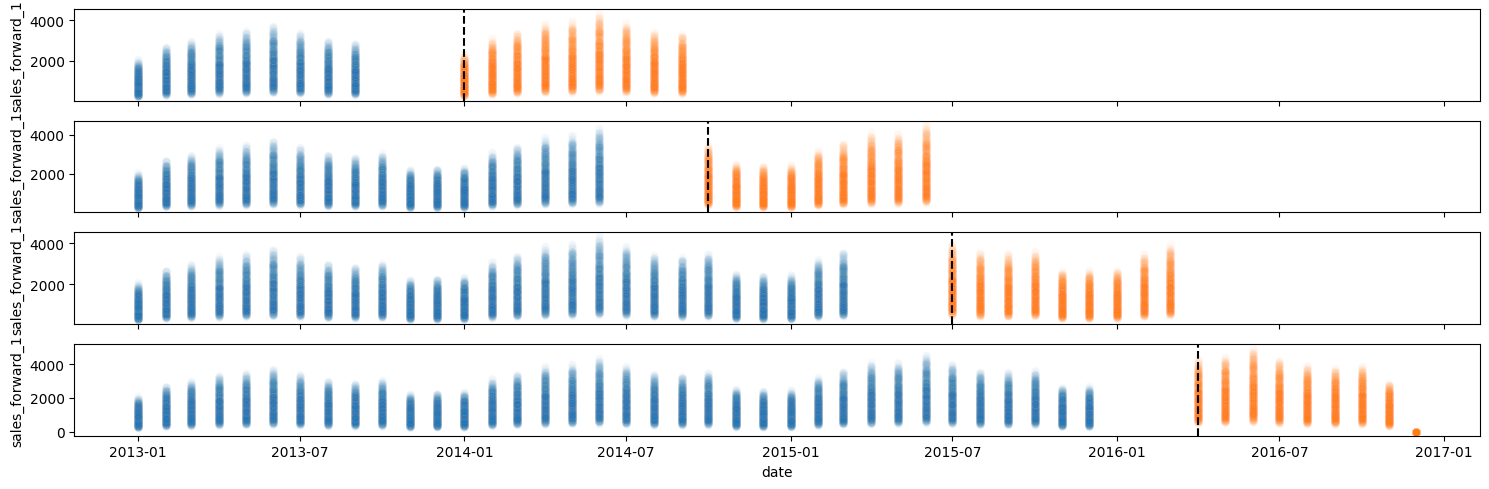

time: 5.03 s (started: 2023-06-09 17:34:52 +00:00)


In [60]:
def show_cross_val_folds(y):
  """
  Essa função usa apenas a label(y) porque é usada apenas para a visualização dos folds.
  """
  tss = TimeSeriesSplit(n_splits=4, test_size=4500, gap=1500)

  fig, axs = plt.subplots(4, 1, figsize=(15, 5), sharex=True)
  axs = axs.ravel()
  index = 0

  for train_indexes, test_indexes in tss.split(y):
    train_set = y.iloc[train_indexes]
    test_set  = y.iloc[test_indexes]
    axs[index].axvline(test_set.index.min(), color='black', ls='--')
    sns.scatterplot(x=train_set.index, y=train_set['sales_forward_1'], ax=axs[index], alpha=0.03)
    sns.scatterplot(x=test_set.index, y=test_set['sales_forward_1'], ax=axs[index], alpha=0.03)
    index += 1
    
  plt.tight_layout()
  plt.show()



show_cross_val_folds(y_train)

In [30]:
def custom_cross_val(model, X, y, pipeline):
  tss = TimeSeriesSplit(n_splits=4, test_size=4500, gap=1500)

  scores = list()
  for train_indexes, valid_indexes in tss.split(X):
    X_train  = X.iloc[train_indexes]
    X_valid  = X.iloc[valid_indexes]
    y_train  = y.iloc[train_indexes]
    y_valid  = y.iloc[valid_indexes]

    X_train_ = pipeline.fit_transform(X_train)
    X_valid_ = pipeline.transform(X_valid)

    model_clone = clone(model)
    model_clone.fit(X_train_, y_train)

    y_pred = model_clone.predict(X_valid_)
    scores.append(smape(y_valid, y_pred))
  return scores

time: 1.04 ms (started: 2023-06-09 17:26:06 +00:00)


Os primeiros folds da validação cruzada são tão pequenos alguns atributos acabam se tornando constantes. A classe PowerTransformer não permite esse tipo de atributo, por isso removi ela do pipeline.

In [31]:
steps_cv = [('pp_lag', pp_lag), 
            ('pp_dates', pp_dates), 
            ('pp_stats', pp_stats), 
            ('pp_cyclical', pp_cyclical), 
            ('pp_imputer', pp_imputer), 
            ('pp_scaler', pp_scaler), ]

pipeline_cv = Pipeline(steps=steps_cv)

time: 926 µs (started: 2023-06-09 17:27:05 +00:00)


## Visualizations

Função para visualização dos resultados.

In [81]:
def show_predictions_scatter(y_true, y_pred):
  fig, axs = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
  axs = axs.ravel()

  for i in range(3):
    sns.scatterplot(x=y_true.index, y=y_true.iloc[:, i], ax=axs[i], alpha=0.03)
    sns.scatterplot(x=y_true.index, y=y_pred[:, i], ax=axs[i], alpha=0.03)
    
  plt.tight_layout()
  plt.show()

time: 1.12 ms (started: 2023-06-09 17:58:57 +00:00)


### RandomForestRegressor

In [90]:
mor  = MultiOutputRegressor(estimator=RandomForestRegressor())
scores = custom_cross_val(mor, X_train, y_train, pipeline_cv)

print(scores)
print(np.mean(scores))
print(np.std(scores))

[42.502653327931355, 42.139617531095574, 41.629589378776735, 77.34571322498923]
50.90439336569822
15.269052982996365
time: 5min 30s (started: 2023-06-09 18:09:30 +00:00)


## LGBMRegressor

In [61]:
mor  = MultiOutputRegressor(estimator=lgb.LGBMRegressor())
scores = custom_cross_val(mor, X_train, y_train, pipeline_cv)

print(scores)
print(np.mean(scores))
print(np.std(scores))

[42.184121067327766, 41.33730157971834, 41.86027672664508, 77.09569621841389]
50.619348898026274
15.289112005838984
time: 8.96 s (started: 2023-06-09 17:35:29 +00:00)


In [62]:
mor  = MultiOutputRegressor(estimator=lgb.LGBMRegressor())
mor.fit(X_train_, y_train)
y_pred = mor.predict(X_test_)
print(smape(y_test, y_pred))

58.92496429974933
time: 7.72 s (started: 2023-06-09 17:36:02 +00:00)


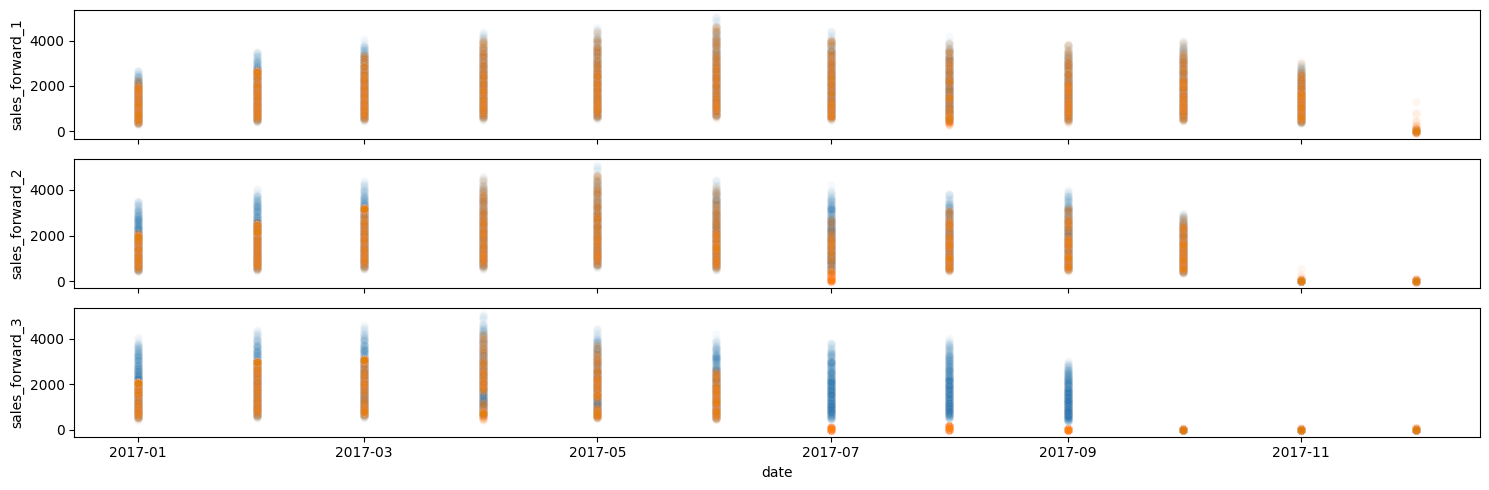

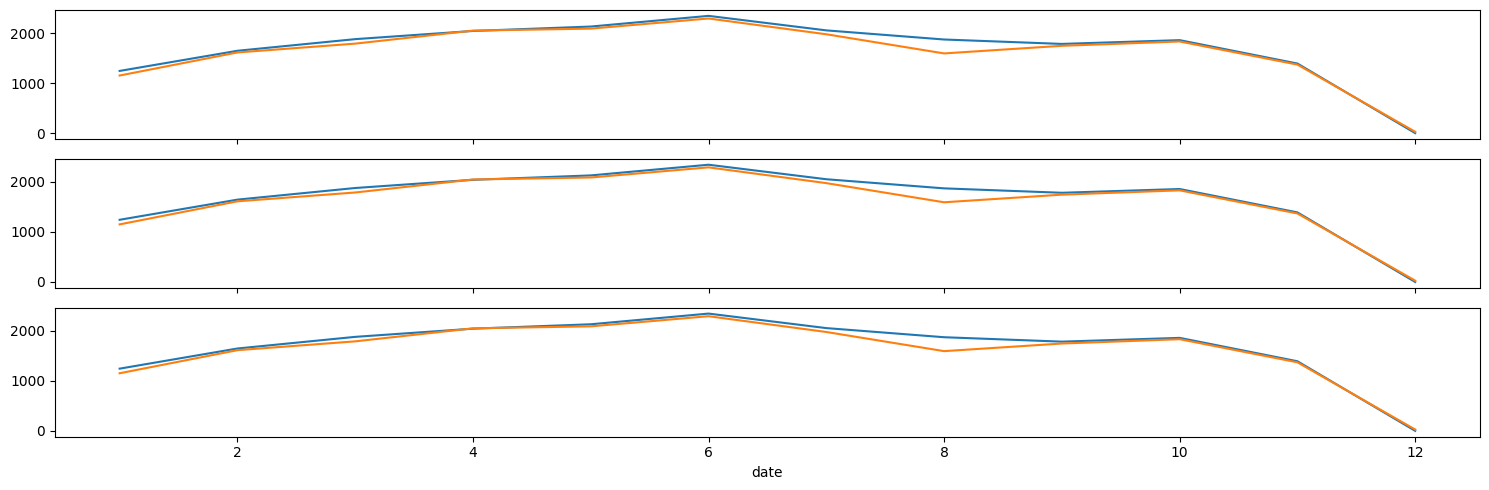

time: 2.91 s (started: 2023-06-09 17:59:41 +00:00)


In [85]:
show_predictions_scatter(y_test, y_pred)

## XGBRegressor

In [86]:
mor  = MultiOutputRegressor(estimator=XGBRegressor())
scores = custom_cross_val(mor, X_train, y_train, pipeline_cv)

print(scores)
print(np.mean(scores))
print(np.std(scores))

[43.53930900208071, 43.898488494111874, 44.26288635481125, 79.26872600134556]
52.74235246308735
15.31714543754423
time: 53.4 s (started: 2023-06-09 18:00:56 +00:00)


In [87]:
mor  = MultiOutputRegressor(estimator=XGBRegressor())
mor.fit(X_train_, y_train)
y_pred = mor.predict(X_test_)
print(smape(y_test, y_pred))

65.74947173886692
time: 37.9 s (started: 2023-06-09 18:04:44 +00:00)


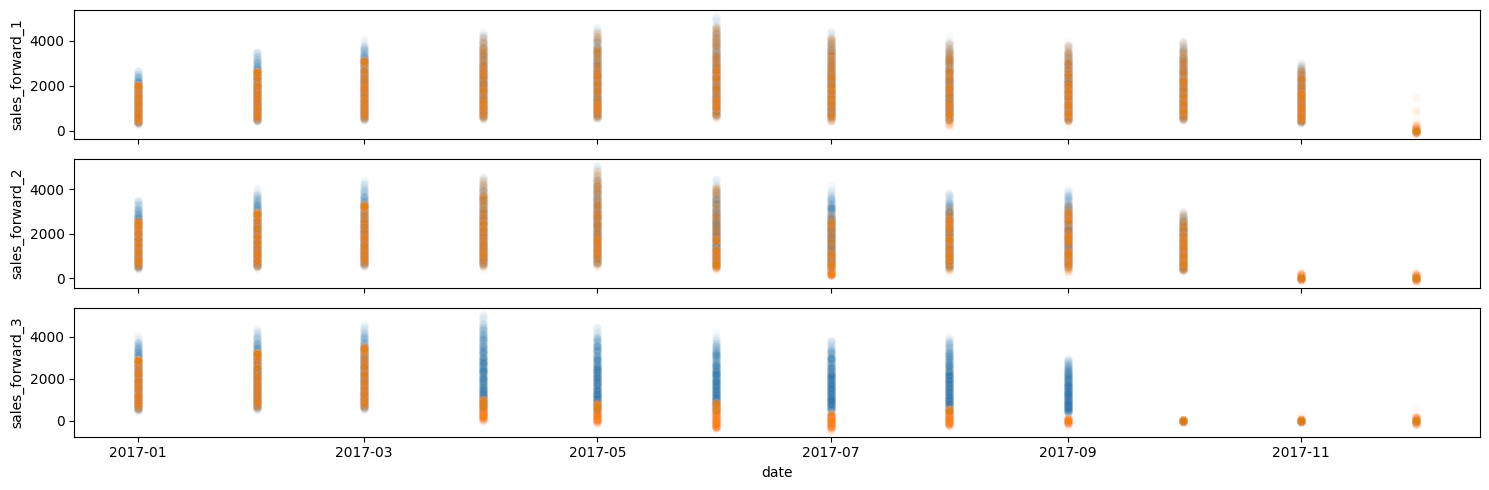

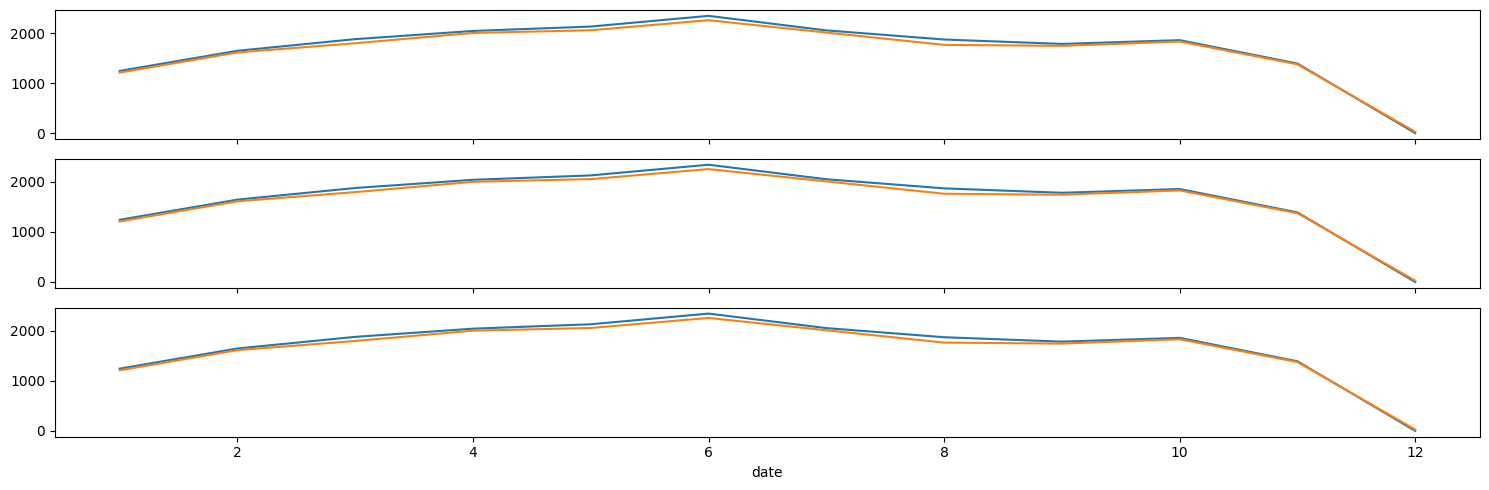

time: 2.88 s (started: 2023-06-09 18:06:19 +00:00)


In [88]:
show_predictions_scatter(y_test, y_pred)